In [3]:
from glob import glob 
#file_list = glob("P" + "*.*", recursive = True)
file_list = glob("Dublin_Jun2014_swath_refl_VIs/Dublin_Jun2014_1_at-sensor_refl_L1G",recursive = True)
for i in file_list:
    print("Element: " + i)
# print("List of filenames:", file_list)

Element: Dublin_Jun2014_swath_refl_VIs/Dublin_Jun2014_1_at-sensor_refl_L1G


In [4]:
import pandas as pd
metadata_list = glob("Dublin_Jun2014_swath_refl_VIs/Dublin_Jun2014_1_at-sensor_refl_L1G.hdr")
header_info = pd.read_table(metadata_list[0], header=None)
# header_info = pd.read_table(file_list[1], header=None)
header_info.columns = ["metadata"]
print(header_info)

                                             metadata
0                                                ENVI
1                                     description = {
2               NASA G-LiHT, Dublin_Jun2014, Track 1}
3                                       samples = 651
4                                      lines   = 8524
5                                       bands   = 114
6                                   header offset = 0
7                           file type = ENVI Standard
8                                       data type = 2
9                                    interleave = bsq
10                              sensor type = Unknown
11                                     byte order = 0
12  map info = {UTM, 1.000, 1.000, 738973.302, 475...
13  coordinate system string = {PROJCS["UTM_Zone_1...
14                         default bands = {54,33,15}
15                      wavelength units = Nanometers
16  z plot titles = {Wavelength (nm), Reflectance ...
17                      defa

In [5]:
print(metadata_list)
print(file_list[0])

['Dublin_Jun2014_swath_refl_VIs/Dublin_Jun2014_1_at-sensor_refl_L1G.hdr']
Dublin_Jun2014_swath_refl_VIs/Dublin_Jun2014_1_at-sensor_refl_L1G


In [6]:
##!pip install spectral
from spectral import *

In [7]:
# img = envi.open(file_list[1], )
# img1 = envi.open(file_list[3], )
# img2 = envi.open(file_list[5], )
img = envi.open(metadata_list[0], )
# img1 = envi.open(metadata_list[1], )
# img2 = envi.open(metadata_list[2], )

In [8]:
#Load image as an array
arr = img.load()
# arr = img
# arr1 = img1.load()
# arr2 = img2.load()

In [9]:
#Functions for working with images
import cv2
import matplotlib.pyplot as plt
import numpy as np

# def show_image(img1,img2,img3):
def show_image(img1):
    fig1, ax1 = plt.subplots(figsize=(5, 5))
    ax1.imshow(img1, cmap = 'gray')
    # ax1.imshow(img2, cmap = 'gray')
    # ax1.imshow(img3, cmap = 'gray')

def increase_brightness(img, value=80):
    img = img.astype(np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def create_rgb(hyper_cube):
    rgb_image = hyper_cube[:,:,[20,36,5]]
    rgb_image = cv2.normalize(rgb_image, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    rgb_image = rgb_image.astype(np.uint8)
    rgb_image = increase_brightness(rgb_image)
    return rgb_image

In [10]:
def spectralSlicing(img, dim):
    #declaring variables
    inBounds = True
    x,y = 0,0
    ret = []
#     print(img.shape)
    while(inBounds):
        #slice dim pixels in x and y and then take all 114 wavelengths 
        frame = img[x:(x+dim),y:(y+dim),:]
        if(frame.any() != 0): #if the Frame is blank, don't append it
            ret.append(frame)
#         print(frame.shape)
        #indexing and edge detection
        x += dim
        if((x+dim) > img.shape[0]):
            x = 0
            y += dim
            if((y+dim) > img.shape[1]):
                inBounds = False
#    print(len(ret))
    return ret

In [11]:
def showframes(frames):
    for i in range(len(frames)):
        frame = create_rgb(frames[i])
        show_image(frame)

In [12]:
miniframes = spectralSlicing(img,240)

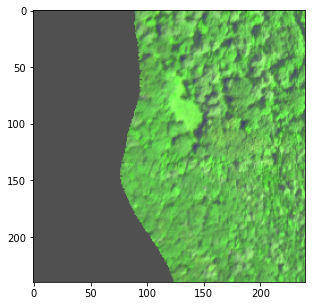

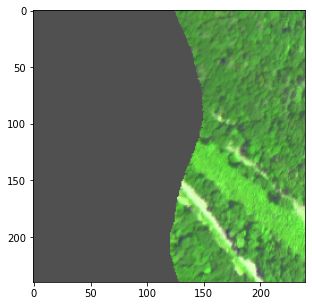

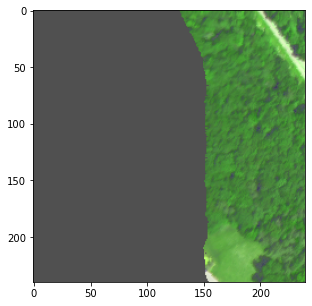

In [13]:
showframes(miniframes[2:5])
# rgb_img = create_rgb(arr) 
# show_image(rgb_img)

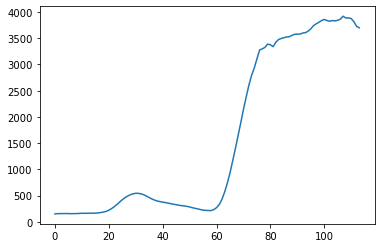

In [14]:
# microframes = spectralSlicing(miniframes[0],80)
plt.plot(miniframes[2][80,130,:])

C:\Users\zajos\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\zajos\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14655
3795


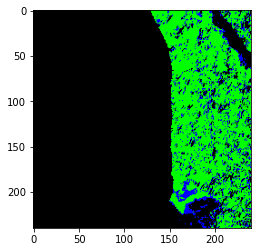

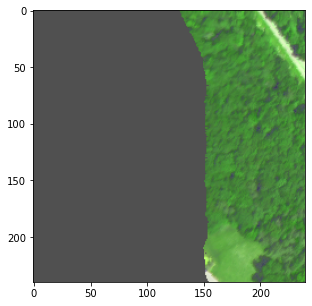

In [15]:
def isTreePixbyPix(frame,treePixel):
#     aTreeFFT = np.fft.fft(treePixel[0:])
    heatmap = np.zeros([frame.shape[0],frame.shape[1],3])  # Creating Heatmap with zeros and ones
    treePixels = []
    otherTreePixels = []
    nonTreePixels = []
    coef = []
    for x in range(frame.shape[0]):
        for y in range(frame.shape[1]):
            cc = np.corrcoef(treePixel, frame[x,y,:])[0,1]
            if(cc > .9990):
                treePixels.append([frame[x,y,:],1])
                heatmap[x,y,1] = 255
                coef.append(cc)
            if(cc > .9980 and cc < .9990):
                otherTreePixels.append([frame[x,y,:],2])
                heatmap[x,y,2] = 255
            if(cc < .9980):
                nonTreePixels.append([frame[x,y,:],0])
#     a = np.histogram(coef[:], bins='auto')
#     plt.plot(a)
#     print(coef[:])
    return treePixels, otherTreePixels, nonTreePixels, heatmap
t, ot, n, hmp = isTreePixbyPix(miniframes[4],miniframes[2][200,150,0:])
plt.imshow(hmp)
showframes(miniframes[4:5])
print(len(t))
print(len(n))

In [16]:
##This Cell will run through all the frames for a bigger data set

referencePixel = miniframes[2][200,150,0:]
data = [miniframes[2][200,150,0:],1]
for i in range(len(miniframes)):
    tr, otr, ntr, hmp = isTreePixbyPix(miniframes[i],referencePixel)
    data = data + tr + otr + ntr
#     print("frame ",i)

frame  0
frame  1
frame  2
frame  3
frame  4
frame  5
frame  6
frame  7
frame  8
frame  9
frame  10
frame  11
frame  12
frame  13
frame  14
frame  15
frame  16
frame  17
frame  18
frame  19
frame  20
frame  21
frame  22
frame  23
frame  24
frame  25
frame  26
frame  27
frame  28
frame  29
frame  30
frame  31
frame  32
frame  33
frame  34
frame  35
frame  36
frame  37
frame  38
frame  39
frame  40
frame  41
frame  42
frame  43
frame  44
frame  45
frame  46
frame  47
frame  48
frame  49
frame  50
frame  51
frame  52
frame  53
frame  54
frame  55
frame  56
frame  57
frame  58
frame  59
frame  60
frame  61
frame  62
frame  63
frame  64


In [38]:
print(data[0:5])
# print(t[0])
# print(data[0][0])


[[array([  92,   91,   90,   90,   88,   88,   88,   85,   83,   81,   80,
         80,   79,   77,   78,   78,   79,   80,   83,   85,   91,   97,
        107,  116,  130,  138,  147,  154,  159,  161,  164,  166,  161,
        156,  151,  143,  136,  132,  127,  124,  122,  121,  119,  118,
        117,  116,  117,  117,  116,  114,  112,  108,  106,  104,  104,
        102,  102,  102,  104,  112,  124,  143,  173,  217,  270,  338,
        414,  497,  594,  700,  815,  928, 1048, 1153, 1234, 1323, 1419,
       1450, 1478, 1511, 1521, 1514, 1550, 1574, 1589, 1607, 1610, 1616,
       1624, 1635, 1640, 1667, 1691, 1712, 1736, 1759, 1767, 1790, 1790,
       1818, 1828, 1850, 1853, 1891, 1897, 1905, 1904, 1910, 1897, 1881,
       1885, 1884, 1880, 1883], dtype=int16), 2], [array([  95,   96,   95,   94,   93,   93,   91,   92,   92,   91,   91,
         91,   91,   90,   91,   89,   89,   92,   94,  102,  115,  134,
        159,  189,  220,  251,  279,  302,  317,  328,  333,  329,  320

In [42]:
#create HP5 file of training data 
import h5py


# t = t + n 
# t2 = t2 + n2
# t = data
# print(len(data))
# print(len(t))
np.random.shuffle(data)
# np.random.shuffle(t2)
trainingData = []
trainingLabels = []
# testingData, testingLabels = zip(*t2)
# trainingData, trainingLabels = zip(data)
# for i in range(len(data)):
#     hyp = np.array(data[i][0])
#     trainingData.append(hyp) 
#     trainingLabels.append(data[i][1])
# print(np.array(data[0]).shape)
print(np.array(data).T.shape)

trainingData = np.array(data)[:,0]
trainingLabels = np.array(data)[:,1]
# hf = h5py.File('treeVSnot.h5','w')
hf.create_dataset('trainingData', data=trainingData)
hf.create_dataset('trainingLabels', data=trainingLabels)
# hf.create_dataset('testingData', data=testingData)
# hf.create_dataset('testingLabels', data=testingLabels)

hf.close()

(1961793,)


<ipython-input-42-e578e92969c4>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(data).T.shape)
<ipython-input-42-e578e92969c4>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trainingData = np.array(data)[:,0]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [29]:
print(type(data[0][1]))

<class 'int'>
